# Tutorial for using stagewiseNN

TODO:
    Add some descriptions

In [1]:
import os
import sys
from pathlib import Path
from typing import Sequence, Mapping, Optional, Union, Callable
import logging
import pandas as pd
import numpy as np
import scanpy as sc

if the package is not installed, you can also import it by appending the swnn's parent directory to ``sys.path``.

In [2]:
ROOT = Path('../')  
sys.path.append(str(ROOT))
import swnn
from swnn import describe_dataframe, set_adata_hvgs, change_names

## 0 Setting paths and load data

In [3]:
DATADIR = ROOT / 'sample_data'
resdir = ROOT / '_temp'
swnn.check_dirs(resdir)

path_adata = DATADIR / 'subsampled_B-L0-0.2.h5ad'

already exists:
	../_temp


Load sample data (an ``AnnData`` object)

In [4]:
adata_raw = sc.read_h5ad(path_adata)
adata_raw

AnnData object with n_obs × n_vars = 29775 × 24410
    obs: 'stage_id', 'primer', 'n_genes', 'n_counts', 'stage_primer', 'stg_leiden', 'stage_stg_leiden', 'refined_group', 'leiden_new', 'parent_bcd', 'lineage', 'stage_name', 'stagewise_cluster'
    uns: 'lineage_colors'

In [5]:
# swnn.describe_dataframe(adata_raw.obs)

## 1 preprocessing

### 1.1 Normalize data and compute HVGs from scratch 

Here we list two ways of normalization (where the first way is most commonly adopted):

In [6]:
# way 1, most commonly adopted
adata_norm = swnn.normalize_default(adata_raw, target_sum=None, copy=True, )

In [7]:
# way 2, less general, but works better for SplitSeq data (our sample data) in practice
adata_norm1 = swnn.normalize_log_then_total(adata_raw, target_sum=None, copy=True, )

### 1.2 Select HVGs from each group (stage) of data

In [8]:
adata = adata_norm1
# adata = adata_norm
hvg_freq, hvg_dict = swnn.groupwise_hvgs_freq(adata, groupby='stage_name')

In [9]:
hvgs = swnn.take_high_freq_elements(hvg_freq, 3)
print('Total of %d HVGs are used.' % len(hvgs))

Total of 4613 HVGs are used.


**NOTE** 

If you have already computed the HVG frequencies, you can directly load them, and take ones with high-frequencies.

```python
hvg_freq = pd.read_csv(path_hvg_freq, index_col=0, header=None).iloc[:, 0].to_dict()
hvgs = swnn.take_high_freq_elements(hvg_freq, min_freq=3)
```

Next, set HVGs to ``adata``

In [10]:
adata = set_adata_hvgs(adata, gene_list=hvgs)

### 1.3 Compute z-scores

Centering and scaling to unit variances, grouped by each "batch" (specified by the ``groupby`` parameter).

In [11]:
batch_key = 'stage_primer'
swnn.wrapper_scale(adata, groupby=batch_key)

adata, adata.X[:2, :]

(AnnData object with n_obs × n_vars = 29775 × 4613
     obs: 'stage_id', 'primer', 'n_genes', 'n_counts', 'stage_primer', 'stg_leiden', 'stage_stg_leiden', 'refined_group', 'leiden_new', 'parent_bcd', 'lineage', 'stage_name', 'stagewise_cluster'
     var: 'highly_variable'
     uns: 'lineage_colors', 'log1p',
 array([[-0.28615636, -0.35525173, -0.12650372, ..., -0.25878315,
         -0.19844045, -0.20785098],
        [-0.19452356, -0.25703438, -0.0802073 , ..., -0.24499079,
         -0.11594469, -0.13195746]]))

## 2 The main process

### 2.0 Setting inputs and parameters

In [12]:
# ====== Inputs ======
data_matrix = adata.X
stage_order = ("B", "G3", "G4", "G5", "G6", "N0", "N1", "N3", "L0")
stage_labels = adata.obs['stage_name']

# only used for building tree, each group will be taken as a tree node
group_labels = adata.obs['stagewise_cluster'] 


# ====== Parameters ======
ks = [10] * 7 + [3] * 2  # specified for different stages
n_pcs = 30     # you can also set it a list like ``ks``
leaf_size = 1  # 1 for exact KNN

Initialize a Builder object:

In [13]:
builder = swnn.Builder(stage_order=stage_order)

### 2.1 Building (stage-wise) single-cell graph

In [14]:
distmat, connect = builder.build_graph(
        X=data_matrix, stage_lbs=stage_labels,
        ks=ks, n_pcs=n_pcs, 
        leaf_size=leaf_size,
    )

perform KNN searching: B in B
perform KNN searching: G3 in B
perform KNN searching: G4 in G3
perform KNN searching: G5 in G4
perform KNN searching: G6 in G5
perform KNN searching: N0 in G6
perform KNN searching: N1 in N0
perform KNN searching: N3 in N1
perform KNN searching: L0 in N3


#### 2.1.1 Further visualization

Compute UMAP based on your precomputed single-cell-graph

In [15]:
swnn.set_precomputed_neighbors(adata, distmat, connect)
sc.tl.umap(adata, min_dist=0.1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


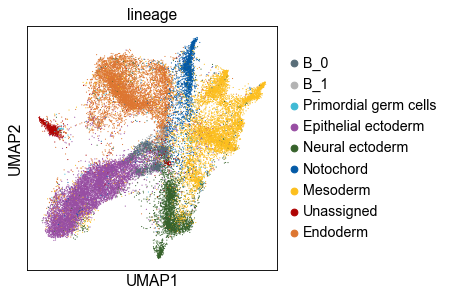

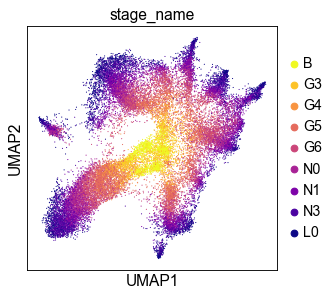

In [16]:
sc.settings.figdir = resdir
sc.set_figure_params(fontsize=14)

sc.pl.umap(adata, color='lineage', ncols=1, save='_lineage.pdf')
sc.pl.umap(adata, color='stage_name', palette='plasma_r', save='_stage.pdf')

### 2.2 Build developmental tree from single-cell graph

In [17]:
edgedf, refined_group_lbs = builder.build_tree(group_labels, stage_labels,)

connecting stage B and G3
---> aggregating edges...
unique labels of rows: ['B_1' 'B_0' 'B_2']
unique labels of columns: ['G3_1' 'G3_0' 'G3_3' 'G3_4' 'G3_2' 'G3_5']
grouping elements (edges)
shape of the one-hot-labels: (1596, 3) (1826, 6)
parent nodes that had no descendent: ['B_2']
Taking descendant-points from other nodes (groups)
pasting stage labels
---> aggregating edges...
unique labels of rows: ['B_1' 'B_0' 'B_2']
unique labels of columns: ['G3_1' 'G3_0' 'G3_3' 'G3_4' 'G3_2' 'G3_5' 'G3_6']
grouping elements (edges)
shape of the one-hot-labels: (1596, 3) (1826, 7)

connecting stage G3 and G4
---> aggregating edges...
unique labels of rows: ['G3_0', 'G3_1', 'G3_2', 'G3_3', 'G3_4', 'G3_5', 'G3_6']
unique labels of columns: ['G4_0' 'G4_4' 'G4_2' 'G4_3' 'G4_1']
grouping elements (edges)
shape of the one-hot-labels: (1826, 7) (1477, 5)
parent nodes that had no descendent: ['G3_3', 'G3_6']
Taking descendant-points from other nodes (groups)
pasting stage labels
---> aggregating edges..

In [18]:
edgedf.head()

,node,parent,prop
0,G3_1,B_1,0.676985
1,G3_0,B_0,0.985633
2,G3_3,B_0,0.581227
3,G3_4,B_0,0.946490
4,G3_2,B_0,0.584790
